In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import random 

from work import handler
from work import casestudy
from work import storm_tracker

from work.plots.hist import simple_hist
from work.transect import add_transects_with_aligned_boxes,make_mask_box

settings_path = 'settings/sam3d.yaml'

# import matplotlib.cm as cm
# from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
# import glob
# import intake
# import dask
# import functools
# import pandas as pd
# dask.config.set({"array.slicing.split_large_chunks": True}) 
import cartopy.crs as ccrs
import cartopy.feature as cf
# import cmocean
# # !pip install easygems
# import tqdm
# import scipy
# import datetime as dt 
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
# from funcs import *


hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
st = storm_tracker.StormTracker(cs, overwrite_storms = False, overwrite = False, verbose = True) #overwrite = True is super long, computes growth rate (triangle fit)

Data loaded from /homedata/mcarenso/shear/SAM3d_Tropics/var_id_days_i_t.json
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 1.42 seconds


In [2]:
test = xr.open_dataset("/bdd/DYAMOND/SAM-4km/OUT_3D/DYAMOND_9216x4608x74_7.5s_4km_4608_0000001440_PP.nc")
z_targets = [300, 2000, 4000, 8000, 12000]
z_indices = [np.abs(test.z.values - target).argmin() for target in z_targets]
z_all = test.z.values.copy()
z_tropo = z_all[:np.abs(test.z.values - 15000).argmin()+1] # L'alitude de la Troposphère est à 15000m à l'équateur max non ? utiliser les pressions ? 
print("z_shear index", z_indices)
print("len z_tropo", len(z_tropo))

p_targets = [975, 800, 600, 350, 200] #mbar or hPa
p_indices = [np.abs(test.p.values-target).argmin() for target in p_targets] ## Est ce que je dois être plus flexible sur l'extraction des coordonnées de pression ? 
                                                                            ## Je peux le faire en extrayant les vents puis interpolant sur ma grille régulière ! 
p_all = test.p.values.copy()
p_tropo = p_all[:np.abs(test.z.values - 15000).argmin()+1]
print("p       index", p_indices)
test.close()

z_shear index [6, 22, 29, 37, 45]
len z_tropo 52
p       index [6, 22, 30, 38, 45]


In [3]:
def add_gridlines(ax):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'gray'}
    gl.ylabel_style = {'size': 10, 'color': 'gray'}
    gl.xlocator = plt.MaxNLocator(integer=True)
    gl.ylocator = plt.MaxNLocator(integer=True)

In [4]:
import os 

duration_min = 12
surfmaxkm2_min = 50000
region_latmin, region_latmax, region_lonmin, region_lonmax = 4, 25, -18, 25
save_storms_path = st.settings["DIR_DATA_OUT"] + f"_high_prop_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"

# os.remove(save_storms_path)

if not os.path.exists(save_storms_path): 
    storms = xr.open_dataset(st.file_storms)
    
    # Filter based on duration and surface area
    ### HIGH PROPAGATION ####
    storms = storms.where(storms.INT_velocityAvg > 3, drop=True)  # 1min
    storms = storms.where(storms.INT_distance > 500, drop=True)  # 1min

    # ### LOW PROPAGATION ####
    # storms = storms.where(storms.INT_velocityAvg <= 3, drop=True)  # 1min
    # storms = storms.where(storms.INT_distance <= 500, drop=True)  # 1min
    
    # Filter based on duration and surface area
    storms = storms.where(storms.INT_duration > duration_min, drop=True)  # 1min
    storms = storms.where(storms.INT_surfmaxkm2_241K > surfmaxkm2_min, drop=True)
    
    # Apply latitude and longitude constraints
    storms = storms.where((storms.INT_latmin >= region_latmin) & (storms.INT_latmax <= region_latmax), drop=True)
    if region_lonmin>=0 : 
        storms = storms.where((storms.INT_lonmin >= region_lonmin) & (storms.INT_lonmax <= region_lonmax), drop=True)
    elif region_lonmin<0:
        storms = storms.where((storms.INT_lonmin >= 360+region_lonmin) | (storms.INT_lonmin <= region_lonmax), drop=True)
    
    # Save the filtered storms data
    storms.to_netcdf(save_storms_path)
    storms.close()
else: 
    storms = xr.open_dataset(save_storms_path)

In [11]:
## FileTracking is ft
ft = storms[[ 
    "INT_UTC_timeInit", "INT_UTC_timeEnd", "INT_duration", "INT_surfcumkm2_241K", "INT_velocityAvg", "INT_surfmaxkm2_241K", ## General characteristics
    "LC_lon", "LC_lat", "LC_UTC_time", "LC_ecc_241K", "LC_orientation_241K", "LC_surfkm2_241K", "LC_tb_90th", "LC_velocity" ## General characteristics
             ]]

## Valid times for 3d var are %6==0 
t=0
ft_3d = ft.sel(time=ft.time[(ft.time - st.i_t_start + cs.settings["TIME_RANGE"][0]) % 6 == 0])

while t<4: 
    iDCS = random.choice(ft_3d.DCS_number.values)
    iDCS=194862
    start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d  = st.get_frame_data(ft, iDCS)
    extents, slices_lon, slices_lat = st.get_extents_slices(lons_3d, lats_3d, large_scale_frame_size = 2.5)

    times_3d_conv = [time for time in times_3d if time <= time_smax + st.settings["TIME_RANGE"][0]]
    t = len(times_3d_conv)

In [12]:
transects = [
    ((lats[0], lons[0]), (lats[i_smax], lons[i_smax])) ## indeed ill defined mf putting y,x instead of x,y....
]
transects

[((10.96, 4.34), (13.17, -0.5))]

/tmp/ipykernel_3451352/2273625346.py:118: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title(f"Sahelian DCS_number : {iDCS}"+"\n"+"age to smax : "+f"{age_to_smax}%" + f" ; w(z={np.int(z_tropo[i_z_plot])}m)")


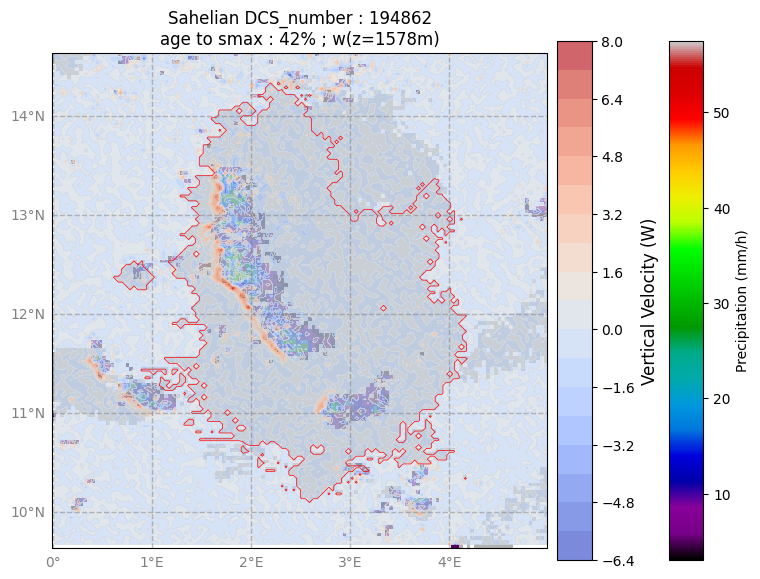

In [52]:
from shapely.geometry import Point, Polygon

## Get systemes moment frame 
i = 1
i_z_plot = 20

slice_lat, slice_lon, extent = slices_lat[i], slices_lon[i], extents[i]
projection = ccrs.PlateCarree(central_longitude = 0)

## Instantiate plot
figsize_ratio = 1.5
fig, ax = plt.subplots(
figsize=(figsize_ratio*(extent[1]-extent[0]), figsize_ratio*(extent[3]-extent[2])), 
            subplot_kw={"projection": projection}, constrained_layout=True)
ax.set_extent(extent, crs=ccrs.PlateCarree())
add_gridlines(ax)

#### BIG TRANSECT #####
# box_width = 0.5
# add_transects_with_aligned_boxes(ax, transects, width =box_width, color='r', linewidth=1, linestyle='--')  # Draw the transects on the map
n_bins = 40

## Load data
le_dico_long = {"latitude" : slice_lat, "longitude" : slice_lon}
le_dico_court = {    "lat" : slice_lat,       "lon" : slice_lon}

u = hdlr.load_var(cs, "U", times_3d[i], z_idx = "L'altitude de la troposphère", sel_dict = le_dico_court).U[0]
v = hdlr.load_var(cs, "V", times_3d[i], z_idx = "L'altitude de la troposphère", sel_dict = le_dico_court).V[0]  
w = hdlr.load_var(cs, "W", times_3d[i], z_idx = "L'altitude de la troposphère", sel_dict = le_dico_court).W[0]
qi = hdlr.load_var(cs, "QI", times_3d[i], z_idx = "L'altitude de la troposphère", sel_dict = le_dico_court).QI[0]


u_transect = np.full(fill_value = float(0), shape=(len(z_tropo), n_bins))
v_transect = np.full(fill_value = float(0), shape=(len(z_tropo), n_bins))
w_transect = np.full(fill_value = float(0), shape=(len(z_tropo), n_bins))
qi_transect = np.full(fill_value = float(0), shape=(len(z_tropo), n_bins))

# for transect in transects: #trasect = transects[0]
#     # start, end point of (lat, lon)
#     start, end = transect[0], transect[1]
#     ##lon, lat centers along the transect

#     bin_sides = np.linspace(start, end, n_bins+1) 
    
#     for i_bin, bin_box in enumerate(zip(bin_sides[:-1], bin_sides[1:])): 
#         bin_box_corners = make_mask_box(bin_box[0], bin_box[1], box_width)

#         bin_box_lats, bin_box_lons = zip(*bin_box_corners)
#         ax.plot(bin_box_lons, bin_box_lats, color='r', linewidth=1, linestyle='--',transform=ccrs.PlateCarree(), label=bin_box_corners[0][0])
#         # Create a polygon from the corners
#         polygon = Polygon(bin_box_corners)

#         lat_grid, lon_grid = np.meshgrid(u['lat'].values, u['lon'].values, indexing='ij')
#         mask = np.zeros(lat_grid.shape, dtype=bool)
#         for i_lat in range(lat_grid.shape[0]):
#             for j_lat in range(lat_grid.shape[1]):
#                 point = Point(lat_grid[i_lat, j_lat], lon_grid[i_lat, j_lat])
#                 if polygon.contains(point):
#                     mask[i_lat, j_lat] = True
#         if not np.all(~mask): 
#             u_box, v_box, w_box, qi_box = u.where(mask).mean(dim=['lat', 'lon']), v.where(mask).mean(dim=['lat', 'lon']), w.where(mask).mean(dim=['lat', 'lon']), qi.where(mask).mean(dim=['lat', 'lon'])
#             u_transect[:, i_bin] = u_box
#             v_transect[:, i_bin] = v_box
#             w_transect[:, i_bin] = w_box
#             qi_transect[:, i_bin] = qi_box


##### PREC #####
prec_cmap =  plt.get_cmap("nipy_spectral")
prec = hdlr.load_var(cs, "Prec", times_3d[i], sel_dict = le_dico_court).sel(le_dico_court).values
prec_masked = np.ma.masked_less_equal(prec, 3)
im = ax.imshow(prec_masked, origin = 'lower', cmap = prec_cmap, interpolation='nearest', alpha = 1, extent = extent)

cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.7, pad=0.02, aspect=15)
cbar.set_label('Precipitation (mm/h)')  # Customize the label as needed

colors = [(1, 1, 1, 0), (0.8, 0.8, 0.8, 0.3), (0.5, 0.5, 0.5, 1)]  # RGBA for light grey to very light grey (with transparency)
colors = [(1, 1, 1, 0), (0.0, 0.0, 0.0, 0.3), (0.5, 0.5, 0.5, 1)]  # RGBA for light grey to very light grey (with transparency)
cmap = LinearSegmentedColormap.from_list("light_grey_scale", colors)

##### CLOUD MASK + CONTOUR ######
seg = hdlr.load_seg(times_3d[i], sel_dict = le_dico_long)[0].values #.sel(le_dico_long)
nan_mask = np.isnan(seg)
output = np.full_like(seg, 0.5, dtype = float)
output[nan_mask] = 0
output[seg == iDCS] = 1
ax.contour(output, levels=[0.75], colors='red', linewidths=0.5, linestyles='solid', extent = extent) #
output[seg == iDCS] = 0.5
ax.imshow(output, origin = 'lower', cmap=cmap, interpolation='nearest', alpha = 1, norm=mcolors.Normalize(vmin=0, vmax=1), extent = extent)


### W ###
# Assuming 'w' is already loaded and has the appropriate dimensions
# I'll use 'lat' and 'lon' from the coordinates of 'w' for plotting
lat = w['lat'].values
lon = w['lon'].values
lon_grid, lat_grid = np.meshgrid(lat, lon, indexing='ij')

contour = ax.contourf(
    lat_grid, lon_grid, w.values[i_z_plot], 
    transform=ccrs.PlateCarree(), 
    cmap='coolwarm',  # Color map for visualization
    levels=20,         # Number of contour levels
    alpha=0.7          # Transparency level
)

# Adding a colorbar for the contour plot
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', shrink=0.7, pad=0.02, aspect=15)
cbar.set_label('Vertical Velocity (W)', fontsize=12)

#### ARROW PROPAGATION MATURATION
# lon_smax, lat_smax = lons[i_smax], lats[i_smax]
# lon_propa, lat_propa = lon_smax - lons[0], lat_smax - lats[0]
# ax.quiver(lons[0], lats[0], lon_propa, lat_propa, scale=1, angles='xy', scale_units='xy')

age_to_smax = int(100*np.round((times_3d[i] - st.settings["TIME_RANGE"][0] - start) / (time_smax - start), 2))

plt.title(f"Sahelian DCS_number : {iDCS}"+"\n"+"age to smax : "+f"{age_to_smax}%" + f" ; w(z={np.int(z_tropo[i_z_plot])}m)")
plt.show()

In [35]:
z_tropo

array([   20.   ,    61.2  ,   104.872,   151.164,   200.234,   252.248,
         307.383,   365.826,   427.776,   493.442,   563.049,   636.832,
         715.042,   797.944,   885.821,   978.97 ,  1078.246,  1186.071,
        1304.677,  1435.146,  1578.66 ,  1736.526,  1910.179,  2101.226,
        2316.409,  2563.87 ,  2848.45 ,  3175.719,  3552.077,  3984.888,
        4466.392,  4966.392,  5466.392,  5966.392,  6466.392,  6966.392,
        7466.392,  7966.392,  8466.392,  8966.392,  9466.392,  9966.391,
       10466.39 , 10966.39 , 11466.39 , 11966.39 , 12466.39 , 12966.39 ,
       13466.39 , 13966.39 , 14466.39 , 14966.39 ], dtype=float32)

In [271]:
w.z

<xarray.DataArray 'z' (z: 52)>
array([   20.   ,    61.2  ,   104.872,   151.164,   200.234,   252.248,
         307.383,   365.826,   427.776,   493.442,   563.049,   636.832,
         715.042,   797.944,   885.821,   978.97 ,  1078.246,  1186.071,
        1304.677,  1435.146,  1578.66 ,  1736.526,  1910.179,  2101.226,
        2316.409,  2563.87 ,  2848.45 ,  3175.719,  3552.077,  3984.888,
        4466.392,  4966.392,  5466.392,  5966.392,  6466.392,  6966.392,
        7466.392,  7966.392,  8466.392,  8966.392,  9466.392,  9966.391,
       10466.39 , 10966.39 , 11466.39 , 11966.39 , 12466.39 , 12966.39 ,
       13466.39 , 13966.39 , 14466.39 , 14966.39 ], dtype=float32)
Coordinates:
    time     float32 240.6
  * z        (z) float32 20.0 61.2 104.9 151.2 ... 1.397e+04 1.447e+04 1.497e+04
Attributes:
    units:      m
    long_name:  height

In [267]:
# lon_grid.shape
w.values[25].shape

(166, 146)

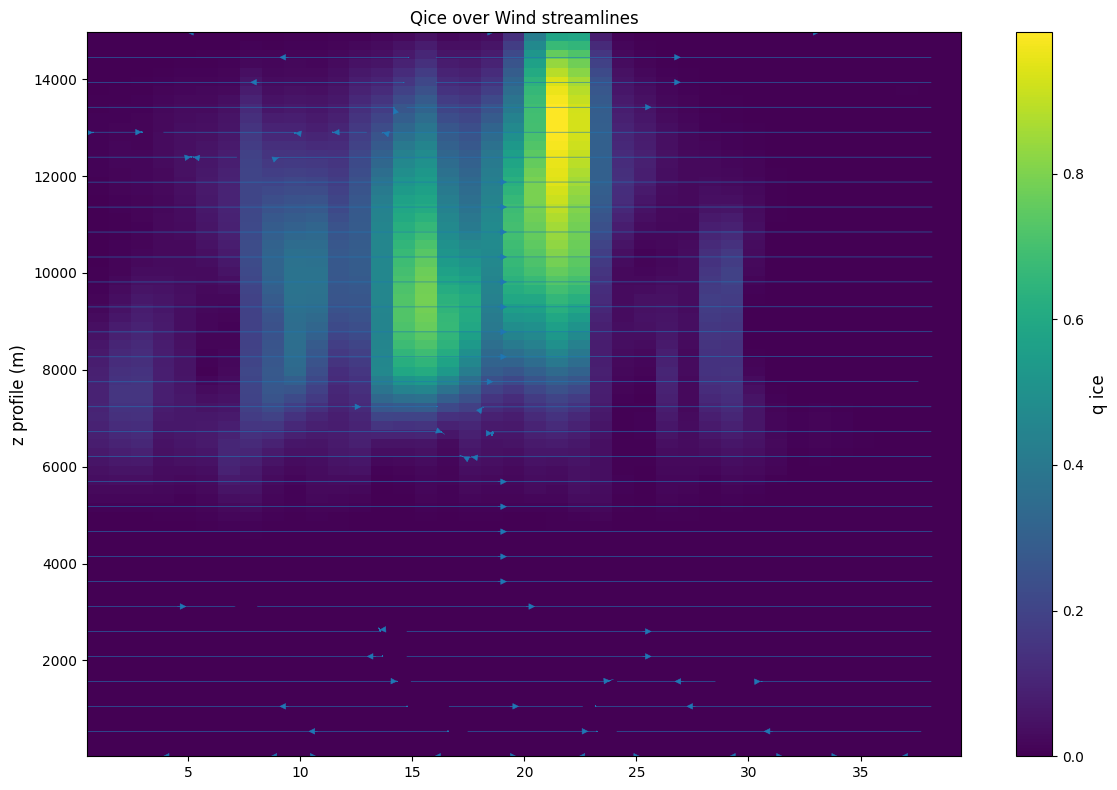

In [243]:
from work.thermo import haversine 
from scipy.interpolate import griddata

x_vals = np.linspace(0.5, n_bins-0.5, n_bins)  # Adjust according to your data
y_vals = np.array(z_tropo)  # Ensure z_all is a NumPy array of actual z-axis values (in meters)

# Original pressure levels and data
original_p_levels = np.array(y_vals)  # Your uneven pressure levels (e.g., in hPa or mb)
new_z_levels = np.linspace(original_p_levels.min(), original_p_levels.max(), num=80)  # Create a regular grid in pressure coordinates

##### DCS MATURATION TOTAL PROPAGATION #####
lon_smax, lat_smax = lons[i_smax], lats[i_smax]
lon_propa, lat_propa = lon_smax - lons[0], lat_smax - lats[0]
lons[0], lats[0], lon_propa, lat_propa #angles='xy', scale_units='xy'

distance_propagation = haversine(lons[0], lats[0], lon_smax, lat_smax)
avg_system_speed = distance_propagation/(i_smax*30*60)
norm_propa = np.sqrt(lon_propa**2 + lat_propa**2) 

u_propa, v_propa = lon_propa/norm_propa, lat_propa/norm_propa

tangeant = u_transect * u_propa + v_transect * v_propa


# Convert your data to an xarray DataArray
ds = xr.Dataset(
    {
        "tangeant": (["z", "x"], tangeant),
        "w_transect": (["z", "x"], w_transect),
        "qi_transect": (["z", "x"], qi_transect)
    },
    coords={
        "z": y_vals,  # Original pressure levels
        "x": x_vals  # Your x-values
    }
)


# Define a regular grid for pressure levels
regular_z_grid = np.linspace(ds.z.min(), ds.z.max(), num=80)

# Interpolate to the regular grid using xarray's built-in interpolation
ds_regular = ds.interp(z=regular_z_grid)

# Extract the interpolated data
tangeant_interpolated = ds_regular['tangeant'].values
w_transect_interpolated = ds_regular['w_transect'].values
qi_transect_interpolated = ds_regular['qi_transect'].values
new_z_levels = ds_regular['z'].values


# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
cax = ax.imshow(qi_transect_interpolated, origin="lower", aspect='auto',
                cmap='viridis',
                extent=[x_vals.min(), x_vals.max(), new_z_levels.min(), new_z_levels.max()])  # Adjusted y-axis

# Add colorbar with label
cbar = fig.colorbar(cax)
cbar.set_label(f'q ice', fontsize=12)  # Replace with the appropriate label

# Add labels and title
ax.set_ylabel('z profile (m)', fontsize=12)  

# Adjust axis limits if necessary
ax.set_xlim([x_vals.min(), x_vals.max()])
ax.set_ylim([new_z_levels.min(), new_z_levels.max()])  # Inverted for pressure coordinate

# ax.pcolormesh(out, cmap='coolwarm')
# cbar = fig.colorbar(ax.pcolormesh(out, cmap='coolwarm'), ax=ax)
# cbar.set_label('Temperature') # Change this label as needed

# wind_norm = np.sqrt(u_transect**2 + v_transect**2 + w_transect**2) # need to interpolate before 
stream = ax.streamplot(x_vals, new_z_levels, tangeant_interpolated, w_transect_interpolated,
                        cmap='hot_r', linewidth=0.4) #color=wind_norm,

# cbar = fig.colorbar(stream.lines, ax=ax)
# cbar.set_label('Wind Speed') # Change this label as needed

# contour = ax.contour(1000 * qr_out, alpha =0.5)
# fig.colorbar(contour, ax=ax)
# cbar.set_label('Rain Content') # Change this label as needed

ax.set_title(f"Qice over Wind streamlines")
# ax.set_xaxis(lon)
plt.tight_layout()
plt.savefig("vertical_transect.png")
plt.show()

In [205]:
len(tangeant.flatten())
len(x_vals)*len(original_p_levels)

2091

In [158]:
x_vals

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40.])

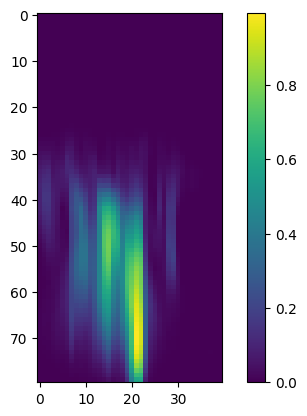

In [239]:
plt.imshow(qi_transect_interpolated)
plt.colorbar()

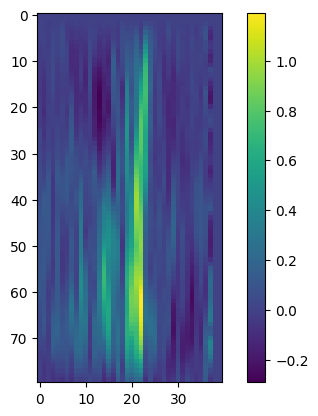

In [237]:
plt.imshow(w_transect_interpolated)
plt.colorbar()

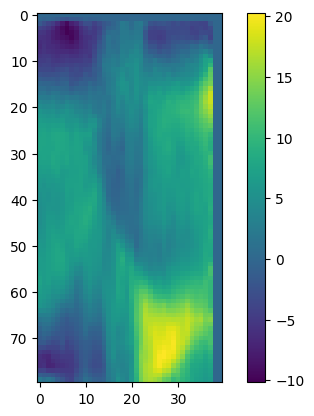

In [240]:
plt.imshow(tangeant_interpolated)
plt.colorbar()

Text(0.5, 1.0, 'w')

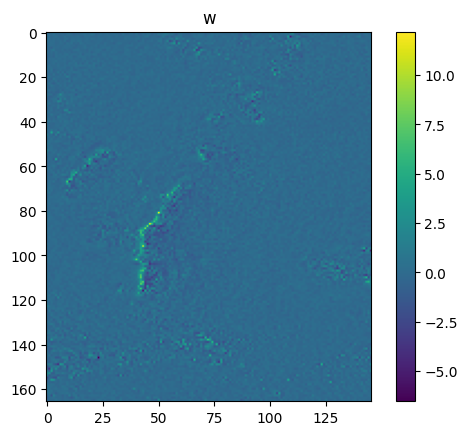

In [257]:
plt.imshow(w[25])
plt.colorbar()
plt.title("w")